# SLC

## Imports

In [1]:
import os
import gc
import math
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms

import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [54]:
data_file = 'l1d'



N_PCA = 30
N_ICA = 20

BATCH_SIZE = 256
PATCH_SIZE = 32
STRIDE = 4
NUM_CLASS = 3      

WEIGHT_DECAY = 0.0005

LR = 0.001

TRAIN_SIZE = 0.8         
VALIDATION_SIZE = 0.2
EPOCH = 10   
VAL_EPOCH = 5   

TEST_PATCH_SIZE = 2
TEST_STRIDE = 1


## Dataset

In [3]:
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 



random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)


raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'




raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    'longisland_2024-06-25T14-52-40Z-l1b.nc',
    'longisland_2024-08-26T14-51-29Z-l1b.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    'marmara_2024-04-16T08-16-38Z-l1b.nc',
    'mvco_2025-03-02T14-55-47Z-l1b.nc',
    'nile_2024-11-02T07-51-59Z-l1b.nc',
    'plocan_2024-12-28T11-00-05Z-l1b.nc',
    'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    'aegean_2024-08-22T08-41-46Z-l1d.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    'barbados_2025-03-04T13-54-23Z-l1d.nc',
    'capetown_2024-11-30T08-25-39Z-l1d.nc',
    'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    'dubai_2024-11-21T06-24-16Z-l1d.nc',
    'erie_2024-09-18T15-53-53Z-l1d.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    'florida_2024-05-21T15-51-31Z-l1d.nc',
    'florida_2024-05-30T15-34-21Z-l1d.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    'longisland_2024-06-25T14-52-40Z-l1d.nc',
    'longisland_2024-08-26T14-51-29Z-l1d.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    'marmara_2024-04-16T08-16-38Z-l1d.nc',
    'mvco_2025-03-02T14-55-47Z-l1d.nc',
    'nile_2024-11-02T07-51-59Z-l1d.nc',
    'plocan_2024-12-28T11-00-05Z-l1d.nc',
    'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]

def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  


if data_file == 'l1a':
    l1a_files, l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
elif data_file == 'l1b':
    l1b_files, l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
elif data_file == 'l1d':
    l1d_files, l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")

# Load Labels and Keep Track of Filenames
labels = []
label_filenames = []
total_labels = len(labels_files)

with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
    for idx, filename in enumerate(labels_files, start=1):
        file_path = os.path.join(labels_path, filename)
        label = np.fromfile(file_path, dtype=np.uint8)
        label = label.reshape((598, 1092))
        labels.append(label)
        label_filenames.append(filename)  # Store filename

        pbar.set_postfix_str(f"Label {idx} / {total_labels}")
        pbar.update(1)

print(f"{data_file} data shape: {l1d_files[0].shape}")
print(f"Labels shape: {labels[0].shape}")
print(f"Filename: {l1d_filenames[0]}")
print(f"Labelname: {label_filenames[0]}")


Number of bands utilized: 30
Training size: 0.8
Epochs: 10
Batch size: 128
Patch size: 8
Learning rate: 0.001
Weight decay: 0.0005


Loading labels: 100%|██████████| 43/43 [00:00<00:00, 646.16file/s, Label 43 / 43]

l1d data shape: (598, 1092, 120)
Labels shape: (598, 1092)
Filename: adriatic_2024-07-18T08-53-45Z-l1d.nc
Labelname: adriatic_2024-07-18T08-53-45Z-l1a_labels.dat


## Plot Captures and Labels

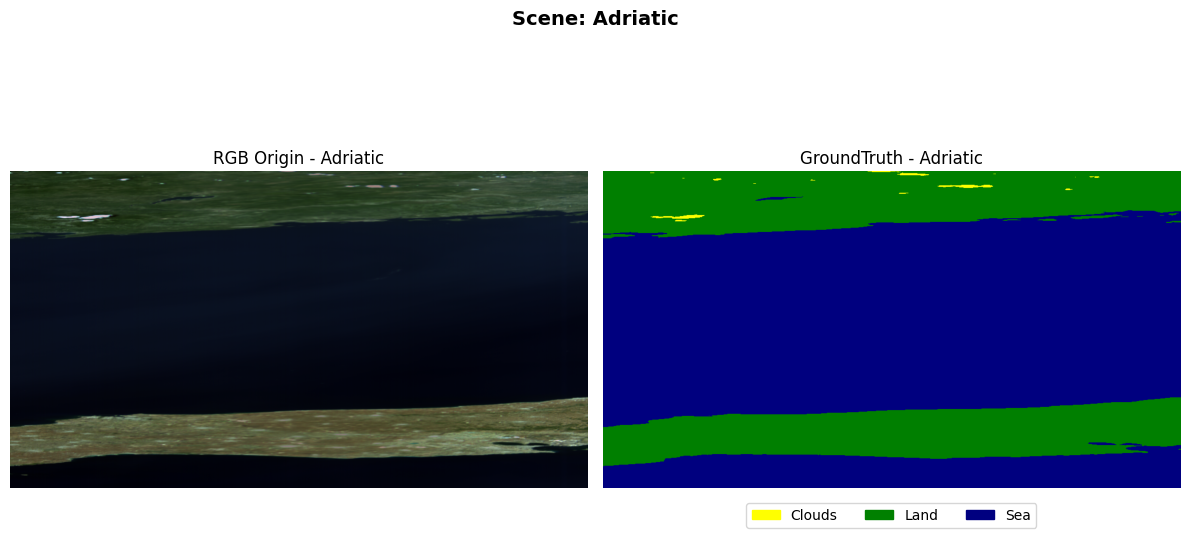

In [ ]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]


axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Pre-process data

### Dimensionality Reduction (PCA)

In [44]:



# def batch_pca_processing(files, selected_bands, num_pca_components, batch_size=4):
 
#     pca_processed_images = []
#     total_batches = math.ceil(len(files) / batch_size)
    
#     with tqdm(total=len(files), desc="Processing PCA for images", unit="image") as pbar:
#         for batch_idx in range(total_batches):
#             start_idx = batch_idx * batch_size
#             end_idx = min((batch_idx + 1) * batch_size, len(files))
#             batch_files = files[start_idx:end_idx]
            
#             batch_results = []
#             for img in batch_files:
#                 # Extract only the selected bands
#                 filtered_data = img[:, :, selected_bands]
                
#                 # Flatten for PCA: Reshape to (pixels, bands)
#                 reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])
                
#                 # Apply PCA
#                 pca = PCA(n_components=num_pca_components)
#                 pca_data = pca.fit_transform(reshaped_data)
                
#                 # Reshape back to (H, W, PCA components)
#                 pca_data = pca_data.reshape(img.shape[0], img.shape[1], num_pca_components)
                
#                 batch_results.append(pca_data)
#                 pbar.update(1)
            
#             # Append batch results
#             pca_processed_images.extend(batch_results)
            
#             # Force garbage collection to free memory
#             gc.collect()
            
#     return np.array(pca_processed_images)

def batch_processing(files, selected_bands, num_pca_components=None, num_ica_components=None, batch_size=4, processing_type="pca"):
    """
    Applies PCA, ICA, or both on hyperspectral images in batches.
    
    Parameters:
        files (list): List of images (numpy arrays).
        selected_bands (list): Indices of spectral bands to process.
        num_pca_components (int, optional): Number of PCA components.
        num_ica_components (int, optional): Number of ICA components.
        batch_size (int): Number of images to process per batch.
        processing_type (str): "pca", "ica", "pca+ica", or "none".
        
    Returns:
        np.array: Processed images.
    """
    processed_images = []
    total_batches = math.ceil(len(files) / batch_size)
    
    with tqdm(total=len(files), desc=f"Processing {processing_type.upper()} for images", unit="image") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(files))
            batch_files = files[start_idx:end_idx]
            
            batch_results = []
            for img in batch_files:
                # Extract only the selected bands
                filtered_data = img[:, :, selected_bands]
                reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])  # Flatten for PCA/ICA
                
                if processing_type == "pca":
                    pca = PCA(n_components=num_pca_components)
                    transformed_data = pca.fit_transform(reshaped_data)
                
                elif processing_type == "ica":
                    ica = FastICA(n_components=num_ica_components, random_state=42)
                    transformed_data = ica.fit_transform(reshaped_data)
                    
                elif processing_type == "pca+ica":
                    pca = PCA(n_components=num_pca_components)
                    pca_data = pca.fit_transform(reshaped_data)
                    
                    ica = FastICA(n_components=num_ica_components, random_state=42)
                    transformed_data = ica.fit_transform(pca_data)
                
                elif processing_type == "none":
                    transformed_data = reshaped_data  # No transformation
                
                # Reshape back to original (H, W, C) format
                num_components = transformed_data.shape[1]
                transformed_data = transformed_data.reshape(img.shape[0], img.shape[1], num_components)
                
                batch_results.append(transformed_data)
                pbar.update(1)
            
            processed_images.extend(batch_results)
            gc.collect()  # Free memory
            
    return np.array(processed_images)



## Patch Extraction

In [45]:
def apply_padding(image, patch_size, stride, mode='reflect'):
    height, width, channels = image.shape

    # Calculate padding needed
    pad_h = (patch_size - (height % stride)) % patch_size
    pad_w = (patch_size - (width % stride)) % patch_size

    # Apply padding to height and width
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode=mode)

    return padded_image

def extract_patches(image, patch_size=PATCH_SIZE, stride=STRIDE):
    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            indices.append((i, j))

    return np.array(patches), indices



class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=PATCH_SIZE, stride=STRIDE, is_pred=False):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size
        self.stride = stride
        self.is_pred = is_pred
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        self.image_to_patch_map = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            img_patches = []
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
        self.total_patches = len(self.patch_indices)
                    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        if not self.is_pred and self.labels is not None:
            label = self.labels[img_idx]
            label_patch = label[i:i+patch_size, j:j+patch_size]
            label_tensor = torch.tensor(label_patch, dtype=torch.long)
            return patch_tensor, label_tensor
        
        return patch_tensor

    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=PATCH_SIZE, stride=STRIDE):
        self.images = images
        self.patch_size = patch_size
        self.stride = stride
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        return patch_tensor, img_idx
    
def reconstruct_image_with_confidence(patches, confidence_scores, original_shape, patch_size=PATCH_SIZE, stride=STRIDE):
    
    H, W = original_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    weights = np.zeros((H, W), dtype=np.float32)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            # Add weighted vote for each pixel
            patch_pred = patches[patch_idx]
            patch_conf = confidence_scores[patch_idx]
            
            reconstructed[i:i+patch_size, j:j+patch_size] += patch_pred * patch_conf
            weights[i:i+patch_size, j:j+patch_size] += patch_conf
            
            patch_idx += 1

    # Normalize by weights
    mask = weights > 0
    reconstructed[mask] = reconstructed[mask] / weights[mask]
    
    # Round to nearest integer for class labels
    return np.round(reconstructed).astype(np.uint8)



## Apply Transformations

In [46]:
if data_file == 'l1a':
    files_to_process = l1a_files
elif data_file == 'l1b':
    files_to_process = l1b_files
elif data_file == 'l1d':
    files_to_process = l1d_files

In [ ]:

if data_file == 'l1a':
    files_to_process = l1a_files
elif data_file == 'l1b':
    files_to_process = l1b_files
elif data_file == 'l1d':
    files_to_process = l1d_files



# Selected spectral bands to use before PCA
selected_bands = [110, 109, 111, 108, 113, 112, 107, 102, 101, 100, 99, 106, 98, 103, 97, 96,
                            81, 80, 79, 78, 77, 76, 75, 74, 82, 85, 73, 86, 84, 95, 88, 87, 72, 89, 71,
                            70, 69, 90, 83, 68, 67, 93, 64, 66, 94, 65, 63, 62, 61, 60, 59, 9, 58, 91,
                            105, 57, 10, 54, 55, 56, 92, 53, 52, 51, 11, 12, 50, 49, 48, 47, 13, 46,
                            14, 6, 4, 45, 3, 5, 7, 34, 8, 15, 16, 25, 44, 33, 43, 35, 40, 36, 17, 41,
                            42, 37, 29, 39, 32, 38, 26, 20, 19, 18, 27, 28, 30, 24, 31, 21, 23, 22, 104]




PROCESSING_TYPE = "pca"  # Choose from "pca", "ica", "pca+ica", "none"

processed_images = batch_processing(
    files=files_to_process,
    selected_bands=selected_bands,
    num_pca_components=N_PCA,
    num_ica_components=N_ICA,
    batch_size=BATCH_SIZE,
    processing_type=PROCESSING_TYPE
)

print(processed_images.shape)

Processing NONE for images: 100%|██████████| 43/43 [02:15<00:00,  3.15s/image]


## Data Split

In [55]:

(training_files, testing_files, 
 training_labels, testing_labels, 
 training_filenames, testing_filenames, 
 training_label_filenames, testing_label_filenames) = train_test_split(
   files_to_process, labels, l1d_filenames, label_filenames, 
    test_size=1 - TRAIN_SIZE, random_state=42
)



(train_images, val_images, 
 train_labels, val_labels, 
 train_filenames, val_filenames, 
 train_label_filenames, val_label_filenames) = train_test_split(
    training_files, training_labels, training_filenames, training_label_filenames,
    test_size=VALIDATION_SIZE, random_state=42
)
 
train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)  
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)  
test_data = TestPatchSet(testing_files, TEST_PATCH_SIZE, TEST_STRIDE)  

# DataLoaders remain unchanged
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"✅ Training & validation DataLoaders ready. No memory overload!")



✅ Training & validation DataLoaders ready. No memory overload!


## Model

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_wavelets import DWTForward

class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=2, base_channels=16, dropout_rate=0.3):
   
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        # Keep track of output channels for each level
        self.level_channels = []
        
        for i in range(levels):
            # Calculate previous channels for feature concatenation
            prev_channels_sum = sum(self.level_channels)
            
            # Input channels include the low-pass and high-pass wavelet coefficients plus previous features
            input_channels = in_channels + 3 * in_channels + prev_channels_sum
            
            # Exponential scaling: base_channels * 2^i
            output_channels = base_channels * (2 ** i)
            self.level_channels.append(output_channels)

            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_rate)
            ))

        # Segmentation Head
        total_channels = sum(self.level_channels)
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(total_channels // 2, total_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Dynamic upsampling layers
        self.upsample_layers = nn.ModuleList()
        current_channels = total_channels // 2
        
        # Create upsampling layers based on levels
        for i in range(levels):
            out_channels = current_channels // 2 if i < levels - 1 else class_nums
            self.upsample_layers.append(
                nn.ConvTranspose2d(current_channels, out_channels, kernel_size=2, stride=2)
            )
            current_channels = out_channels

    def forward(self, x):
        features = []
        low_pass = x
        
        # Wavelet processing
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)

        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)

        # Dynamic upsampling based on number of levels
        for upsample_layer in self.upsample_layers:
            out = upsample_layer(out)

        return out

num_components = 120


# Initialize the model
net = WaveletCNN(in_channels=num_components , class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, num_components,PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, num_components, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 120, 32, 32])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 120, 32, 32]   [1, 3, 32, 32]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 120, 32, 32]   [1, 120, 16, 16]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        7,696              [1, 1]             1,970,176          [1, 480, 16, 16]   [1, 16, 16, 16]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 16, 16, 1

## Training

In [59]:
# First, add the focal loss implementation
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = torch.nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [61]:
import torch
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")


model = WaveletCNN(num_components, class_nums=NUM_CLASS).to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
#loss_func = torch.nn.CrossEntropyLoss()
loss_func = FocalLoss(alpha=1, gamma=2)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


loss_list, acc_list, val_acc_list, val_epoch_list = [], [], [], []
best_val_acc = 0.0
patience = 15 
early_stop_counter = 0
epoch_stop_threshold = 0.05  

train_num = len(train_loader.dataset) * PATCH_SIZE * PATCH_SIZE
val_num = len(val_loader.dataset) * PATCH_SIZE * PATCH_SIZE

start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.0
        train_acc = 0
        prev_batch_loss = None  

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()

      
        loss_list.append(avg_loss / train_num)
        acc_list.append(train_acc / train_num)
        print(f"Epoch {e}/{EPOCH} - Loss: {loss_list[-1]:.4f}  Train Acc: {acc_list[-1]:.4f}")

       
        model.eval()
        val_acc = 0
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
                data, target = data.to(device), target.to(device)
                out = model(data)
                target = target - 1  
                _, pred = torch.max(out, dim=1)
                val_acc += (pred == target).sum().item()

        val_acc /= val_num
        val_acc_list.append(val_acc)
        val_epoch_list.append(e)
        print(f"Epoch {e}/{EPOCH} - Validation Acc: {val_acc:.4f}")

       
        scheduler.step(val_acc_list[-1])

   
        current_lr = optimizer.param_groups[0]['lr']
        print(f"📉 Current learning rate: {current_lr}")

        
        save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc:.4f}.pth")
        torch.save(model.state_dict(), save_name)
        print(f"💾 Model saved: {save_name}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0  
        else:
            early_stop_counter += 1 

      
        if early_stop_counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {e}. Best val_acc: {best_val_acc:.4f}")
            break
        
        epoch_end_time = time.time()
        print(f"✅ Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")

except Exception as exc:
    print(f"⚠️ Training interrupted: {exc}")
finally:
    total_time = time.time() - start_time
    print(f"🏁 Training completed in {total_time:.2f} seconds.")
    print(f"🛑 Stopped at epoch {e}")

  
    best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)

  
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(np.arange(len(loss_list)), loss_list, label="Training Loss")
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")

    ax2.plot(np.arange(len(acc_list)), acc_list, label="Train Acc")
    ax2.plot(val_epoch_list, val_acc_list, label="Val Acc")
    ax2.set_title("Training & Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.show()

print(f"🎯 Best model retained: {best_model_path}")


Using device: cuda


100%|██████████| 3984/3984 [04:08<00:00, 16.05it/s]


Epoch 0/10 - Loss: 0.0000  Train Acc: 0.9581


Training::  10%|█         | 1/10 [05:17<47:36, 317.42s/it]

Epoch 0/10 - Validation Acc: 0.9243
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_0_acc_0.9243.pth
✅ Epoch 1/10 completed in 317.42 seconds.


100%|██████████| 3984/3984 [04:08<00:00, 16.01it/s]


Epoch 1/10 - Loss: 0.0000  Train Acc: 0.9662


Training::  20%|██        | 2/10 [10:29<41:53, 314.15s/it]

Epoch 1/10 - Validation Acc: 0.9422
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_1_acc_0.9422.pth
✅ Epoch 2/10 completed in 311.86 seconds.


100%|██████████| 3984/3984 [04:06<00:00, 16.15it/s]


Epoch 2/10 - Loss: 0.0000  Train Acc: 0.9670


Training::  30%|███       | 3/10 [15:38<36:24, 312.12s/it]

Epoch 2/10 - Validation Acc: 0.9100
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_2_acc_0.9100.pth
✅ Epoch 3/10 completed in 309.71 seconds.


100%|██████████| 3984/3984 [04:10<00:00, 15.89it/s]


Epoch 3/10 - Loss: 0.0000  Train Acc: 0.9673


Training::  40%|████      | 4/10 [20:53<31:17, 312.94s/it]

Epoch 3/10 - Validation Acc: 0.9176
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_3_acc_0.9176.pth
✅ Epoch 4/10 completed in 314.18 seconds.


100%|██████████| 3984/3984 [04:11<00:00, 15.85it/s]


Epoch 4/10 - Loss: 0.0000  Train Acc: 0.9656


Training::  50%|█████     | 5/10 [26:07<26:07, 313.51s/it]

Epoch 4/10 - Validation Acc: 0.9261
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_4_acc_0.9261.pth
✅ Epoch 5/10 completed in 314.53 seconds.


100%|██████████| 3984/3984 [04:10<00:00, 15.89it/s]


Epoch 5/10 - Loss: 0.0000  Train Acc: 0.9675


Training::  60%|██████    | 6/10 [31:21<20:55, 313.75s/it]

Epoch 5/10 - Validation Acc: 0.9100
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_5_acc_0.9100.pth
✅ Epoch 6/10 completed in 314.21 seconds.


100%|██████████| 3984/3984 [04:10<00:00, 15.93it/s]


Epoch 6/10 - Loss: 0.0000  Train Acc: 0.9704


Training::  70%|███████   | 7/10 [36:35<15:40, 313.58s/it]

Epoch 6/10 - Validation Acc: 0.9402
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_6_acc_0.9402.pth
✅ Epoch 7/10 completed in 313.23 seconds.


100%|██████████| 3984/3984 [04:12<00:00, 15.77it/s]


Epoch 7/10 - Loss: 0.0000  Train Acc: 0.9707


Training::  80%|████████  | 8/10 [41:50<10:28, 314.24s/it]

Epoch 7/10 - Validation Acc: 0.9059
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_7_acc_0.9059.pth
✅ Epoch 8/10 completed in 315.66 seconds.


100%|██████████| 3984/3984 [04:10<00:00, 15.92it/s]


Epoch 8/10 - Loss: 0.0000  Train Acc: 0.9707


Training::  90%|█████████ | 9/10 [47:04<05:14, 314.09s/it]

Epoch 8/10 - Validation Acc: 0.9128
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_8_acc_0.9128.pth
✅ Epoch 9/10 completed in 313.76 seconds.


100%|██████████| 3984/3984 [04:10<00:00, 15.92it/s]


Epoch 9/10 - Loss: 0.0000  Train Acc: 0.9712


Training:: 100%|██████████| 10/10 [52:17<00:00, 313.74s/it]

Epoch 9/10 - Validation Acc: 0.8829
📉 Current learning rate: 0.00025
💾 Model saved: results\l1d\epoch_9_acc_0.8829.pth
✅ Epoch 10/10 completed in 312.84 seconds.
🏁 Training completed in 3137.42 seconds.
🛑 Stopped at epoch 9


NameError: name 'get_best_model' is not defined

### Save Best Model

In [62]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Inference and Evaluation

C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_22992\2388449327.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mode

best model:epoch_1_acc_0.9422.pth
✅ Loading Best Model from: results\l1d\epoch_1_acc_0.9422.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/9 - Scene: solbergstrand_2024-07-08T09-39-39Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 1: 100%|██████████| 615/615 [00:12<00:00, 50.77it/s]


Unique classes in prediction: [0 1 2]


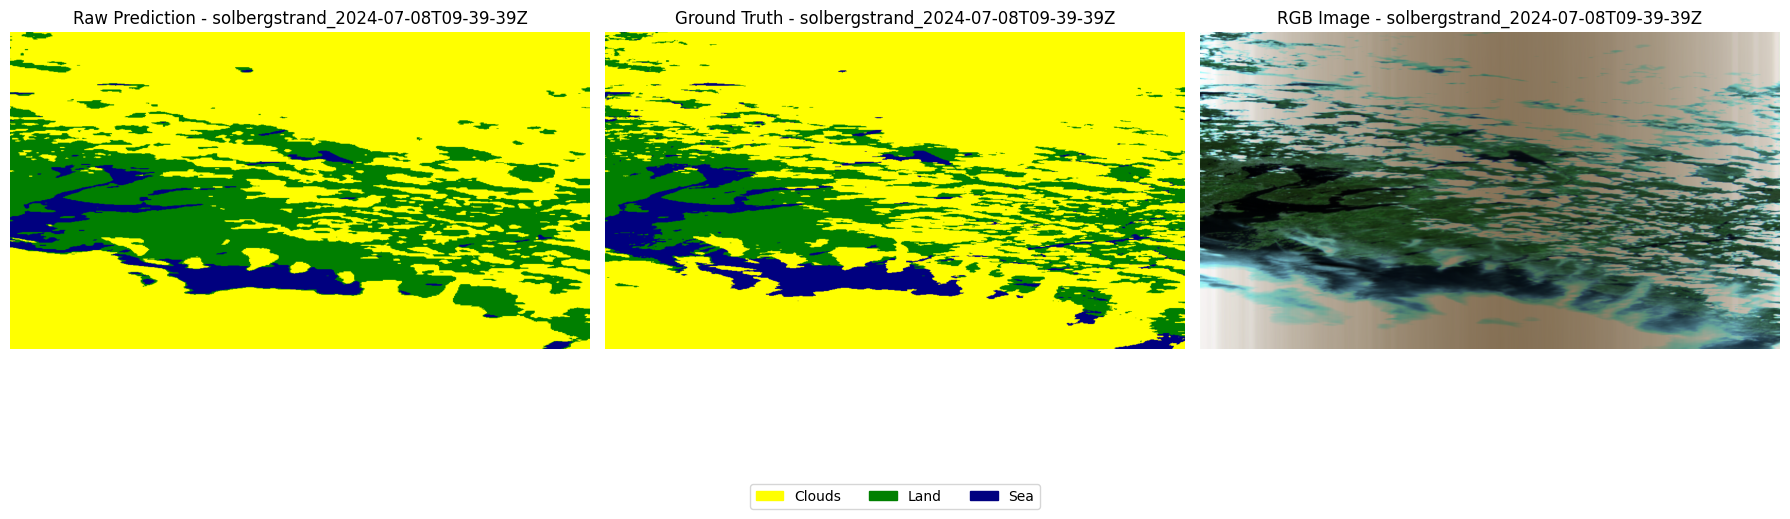

Scene: solbergstrand_2024-07-08T09-39-39Z
OA: 0.8957468117167113
AA: 0.8290854181777787
Kappa: 0.777627849594379
              precision    recall  f1-score   support

      Clouds     0.9644    0.9102    0.9365    457930
        Land     0.7202    0.9454    0.8176    143056
         Sea     0.9957    0.6316    0.7729     52030

    accuracy                         0.8957    653016
   macro avg     0.8934    0.8291    0.8423    653016
weighted avg     0.9134    0.8957    0.8974    653016


Processing Test Image 2/9 - Scene: lagunaDeTerminos_2024-12-06T16-07-50Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2: 100%|██████████| 615/615 [00:12<00:00, 49.66it/s]


Unique classes in prediction: [0 1 2]


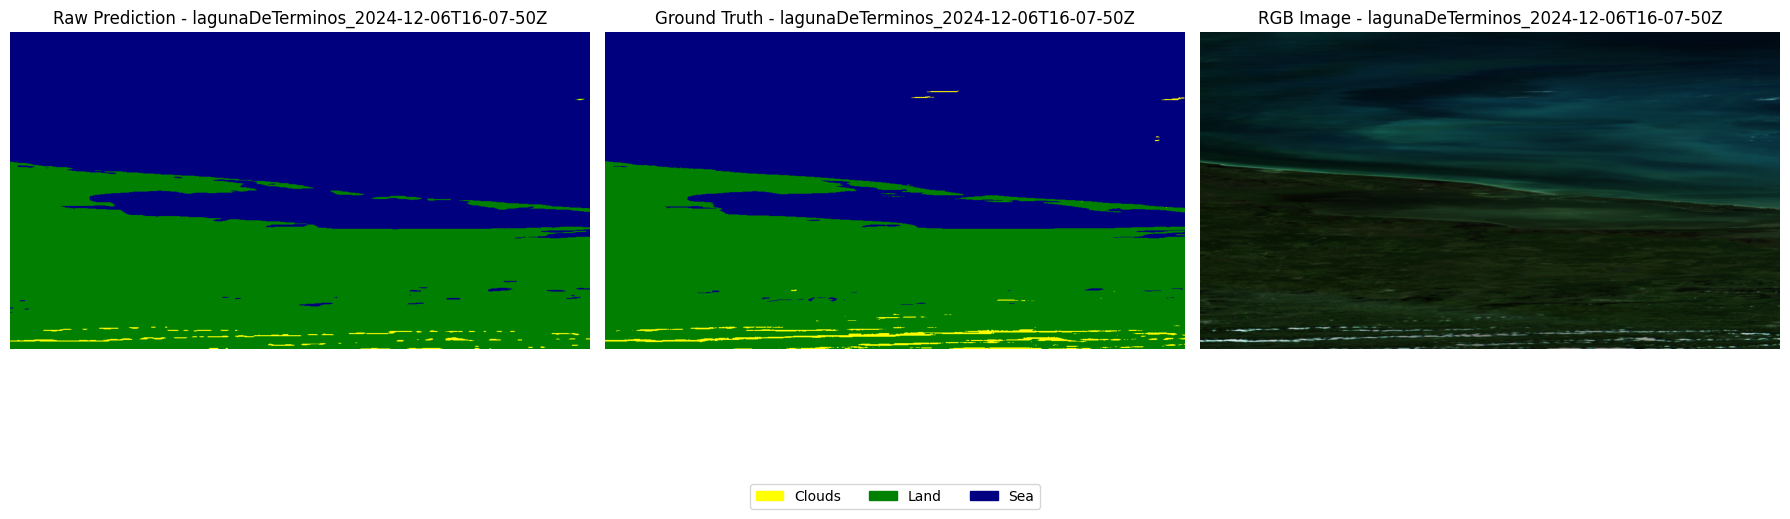

Scene: lagunaDeTerminos_2024-12-06T16-07-50Z
OA: 0.9804139561664645
AA: 0.7810096439584334
Kappa: 0.96091247160418
              precision    recall  f1-score   support

      Clouds     0.9945    0.3682    0.5375      8872
        Land     0.9800    0.9756    0.9778    282426
         Sea     0.9806    0.9992    0.9898    361718

    accuracy                         0.9804    653016
   macro avg     0.9850    0.7810    0.8350    653016
weighted avg     0.9805    0.9804    0.9785    653016


Processing Test Image 3/9 - Scene: lakewinnipeg_2024-08-13T17-07-06Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3: 100%|██████████| 615/615 [00:12<00:00, 48.80it/s]


Unique classes in prediction: [0 1 2]


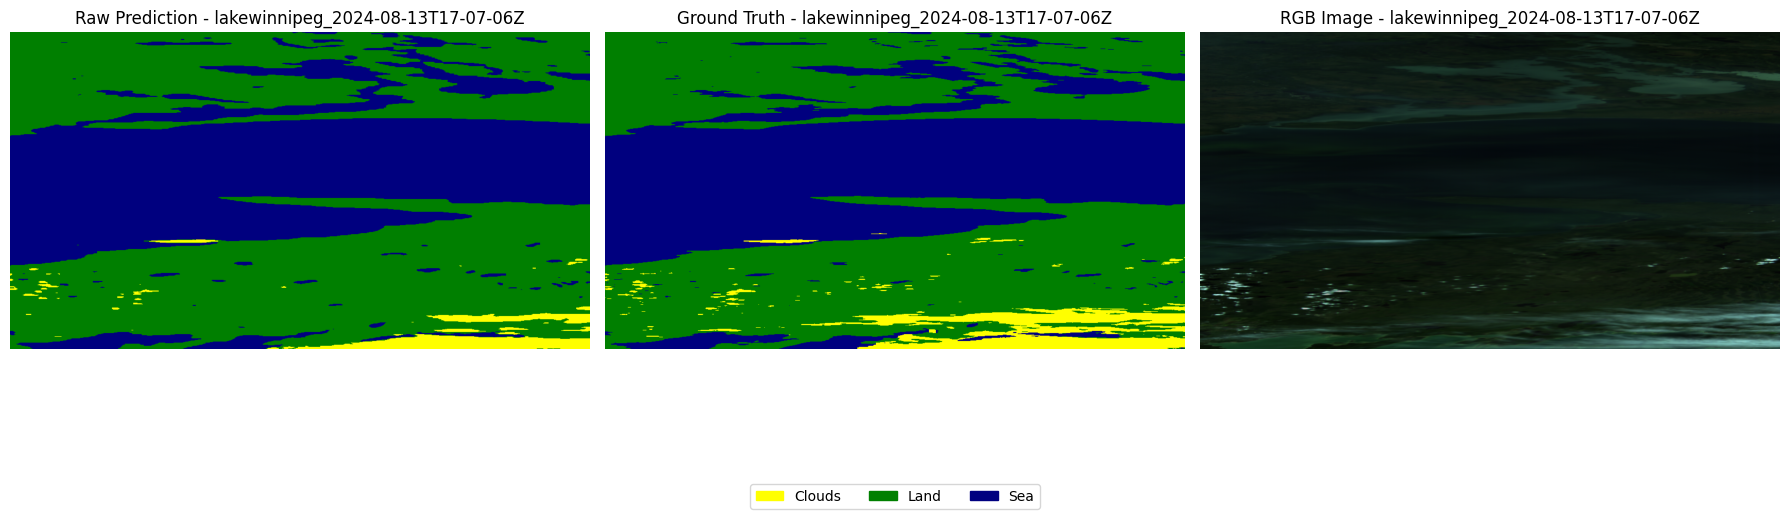

Scene: lakewinnipeg_2024-08-13T17-07-06Z
OA: 0.9609014174231566
AA: 0.8258347203557467
Kappa: 0.9254232106725936
              precision    recall  f1-score   support

      Clouds     0.9698    0.5069    0.6658     31945
        Land     0.9527    0.9785    0.9654    358151
         Sea     0.9716    0.9921    0.9818    262920

    accuracy                         0.9609    653016
   macro avg     0.9647    0.8258    0.8710    653016
weighted avg     0.9611    0.9609    0.9573    653016


Processing Test Image 4/9 - Scene: sicilychannel_2024-12-28T09-23-44Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4: 100%|██████████| 615/615 [00:12<00:00, 48.20it/s]


Unique classes in prediction: [0 1 2]


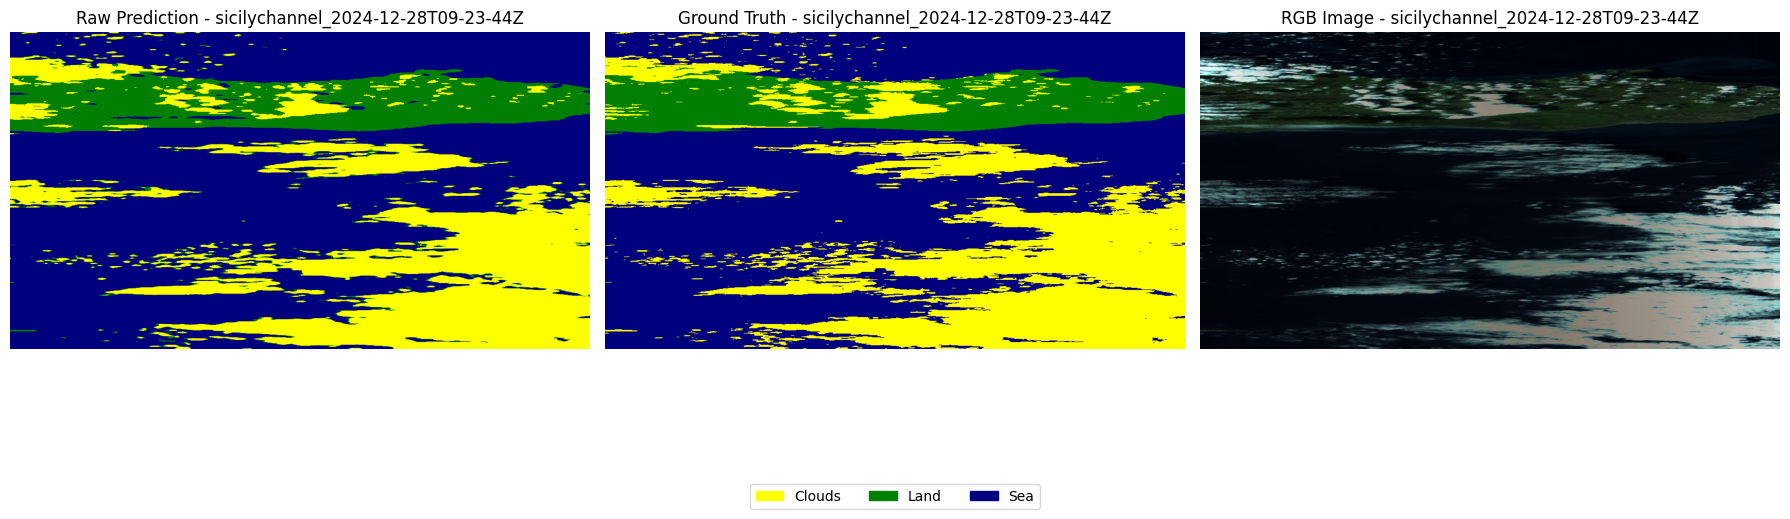

Scene: sicilychannel_2024-12-28T09-23-44Z
OA: 0.9442218873657001
AA: 0.9292621614935427
Kappa: 0.9019986862813696
              precision    recall  f1-score   support

      Clouds     0.9725    0.8772    0.9224    197288
        Land     0.8182    0.9267    0.8691     84993
         Sea     0.9630    0.9839    0.9733    370735

    accuracy                         0.9442    653016
   macro avg     0.9179    0.9293    0.9216    653016
weighted avg     0.9470    0.9442    0.9444    653016


Processing Test Image 5/9 - Scene: rogaland_2024-06-01T09-56-49Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 5: 100%|██████████| 615/615 [00:12<00:00, 49.60it/s]


Unique classes in prediction: [0 1 2]


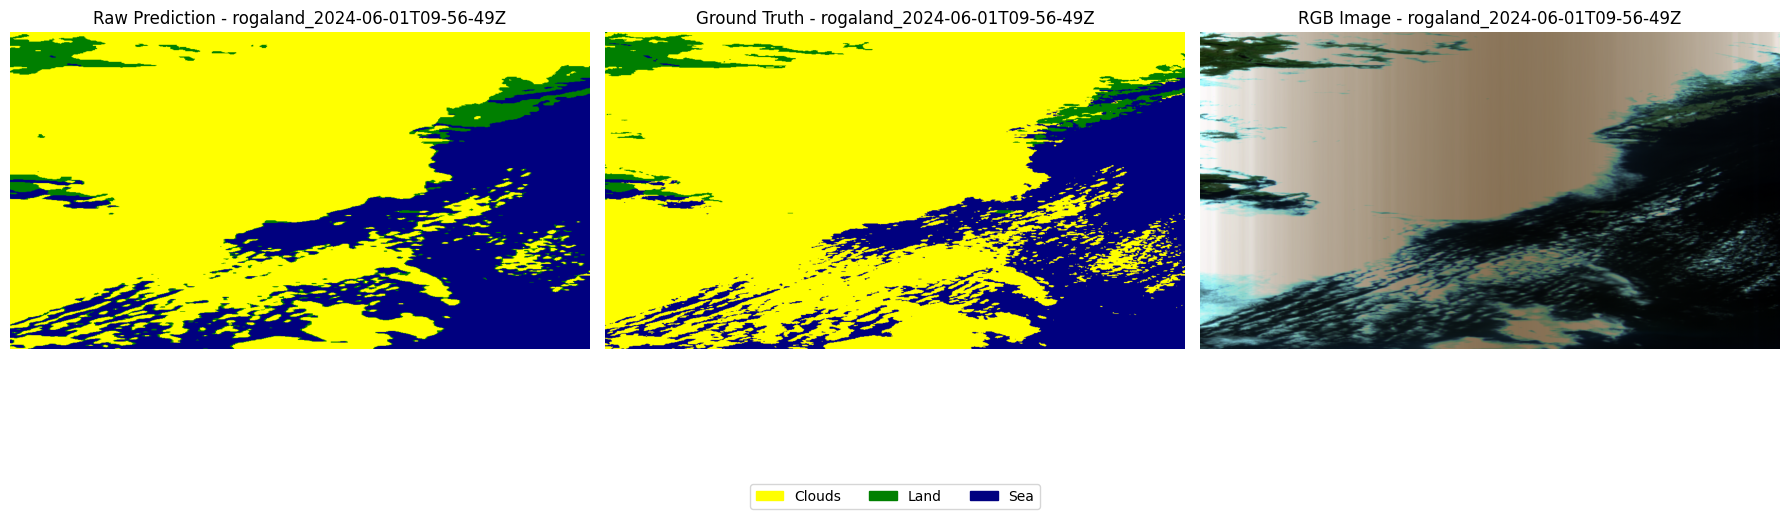

Scene: rogaland_2024-06-01T09-56-49Z
OA: 0.9265760716429613
AA: 0.9064405194826936
Kappa: 0.8429937637246149
              precision    recall  f1-score   support

      Clouds     0.9889    0.9156    0.9509    457924
        Land     0.5138    0.8335    0.6357     25547
         Sea     0.8768    0.9702    0.9212    169545

    accuracy                         0.9266    653016
   macro avg     0.7932    0.9064    0.8359    653016
weighted avg     0.9412    0.9266    0.9308    653016


Processing Test Image 6/9 - Scene: tenerife_2025-01-17T11-17-36Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 6: 100%|██████████| 615/615 [00:12<00:00, 50.04it/s]


Unique classes in prediction: [0 1 2]


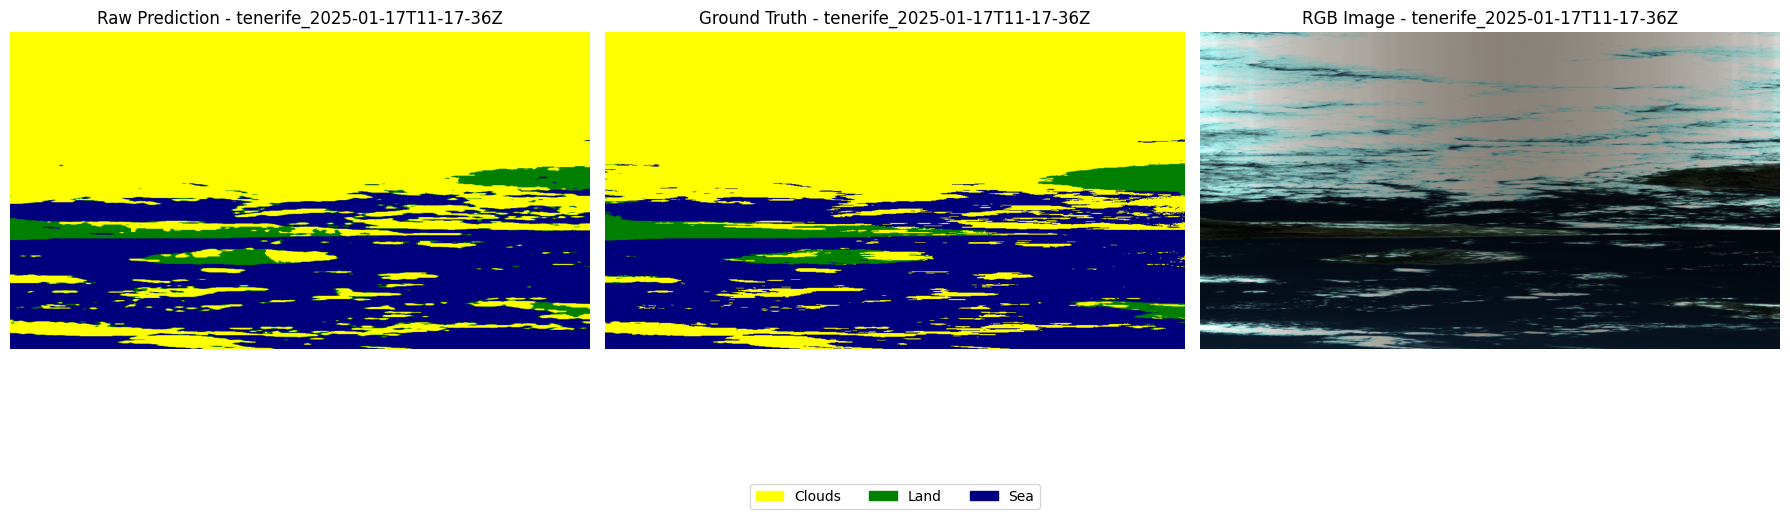

Scene: tenerife_2025-01-17T11-17-36Z
OA: 0.9523135727149105
AA: 0.8887259123561565
Kappa: 0.9090034424176863
              precision    recall  f1-score   support

      Clouds     0.9538    0.9928    0.9729    377402
        Land     0.7019    0.7557    0.7278     35376
         Sea     0.9927    0.9177    0.9537    240238

    accuracy                         0.9523    653016
   macro avg     0.8828    0.8887    0.8848    653016
weighted avg     0.9544    0.9523    0.9526    653016


Processing Test Image 7/9 - Scene: aquawatchplymouth_2025-03-04T10-37-14Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 7: 100%|██████████| 615/615 [00:12<00:00, 49.75it/s]


Unique classes in prediction: [0 1 2]


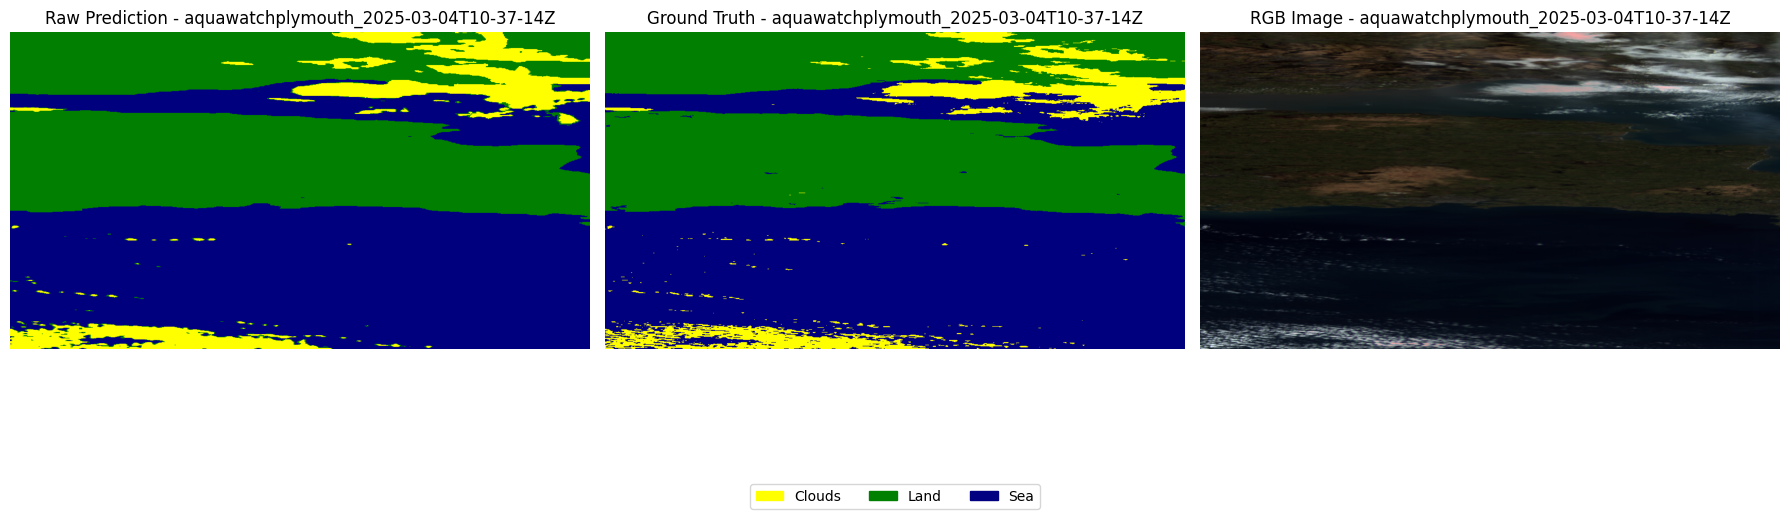

Scene: aquawatchplymouth_2025-03-04T10-37-14Z
OA: 0.9673377068862019
AA: 0.9396003297189512
Kappa: 0.9425227155309006
              precision    recall  f1-score   support

      Clouds     0.8288    0.8665    0.8473     51662
        Land     0.9713    0.9777    0.9745    274573
         Sea     0.9871    0.9746    0.9808    326781

    accuracy                         0.9673    653016
   macro avg     0.9291    0.9396    0.9342    653016
weighted avg     0.9680    0.9673    0.9676    653016


Processing Test Image 8/9 - Scene: flindersIsland_2024-11-09T23-33-38Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 8: 100%|██████████| 615/615 [00:12<00:00, 49.45it/s]


Unique classes in prediction: [0 1 2]


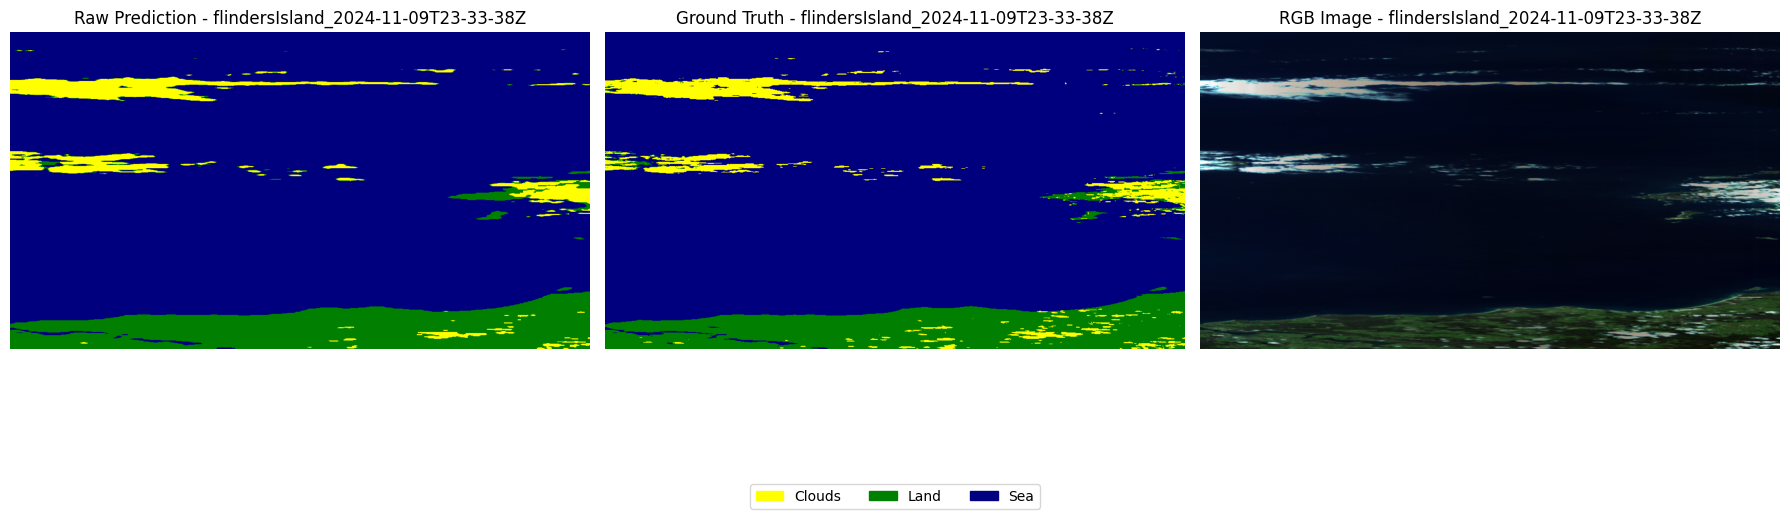

Scene: flindersIsland_2024-11-09T23-33-38Z
OA: 0.9829958224607054
AA: 0.9405844175523365
Kappa: 0.9412847454877838
              precision    recall  f1-score   support

      Clouds     0.8809    0.8606    0.8707     30289
        Land     0.9233    0.9694    0.9458     77301
         Sea     0.9975    0.9917    0.9946    545426

    accuracy                         0.9830    653016
   macro avg     0.9339    0.9406    0.9370    653016
weighted avg     0.9833    0.9830    0.9831    653016


Processing Test Image 9/9 - Scene: dubai_2024-11-21T06-24-16Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 9: 100%|██████████| 615/615 [00:12<00:00, 48.89it/s]


Unique classes in prediction: [0 1 2]


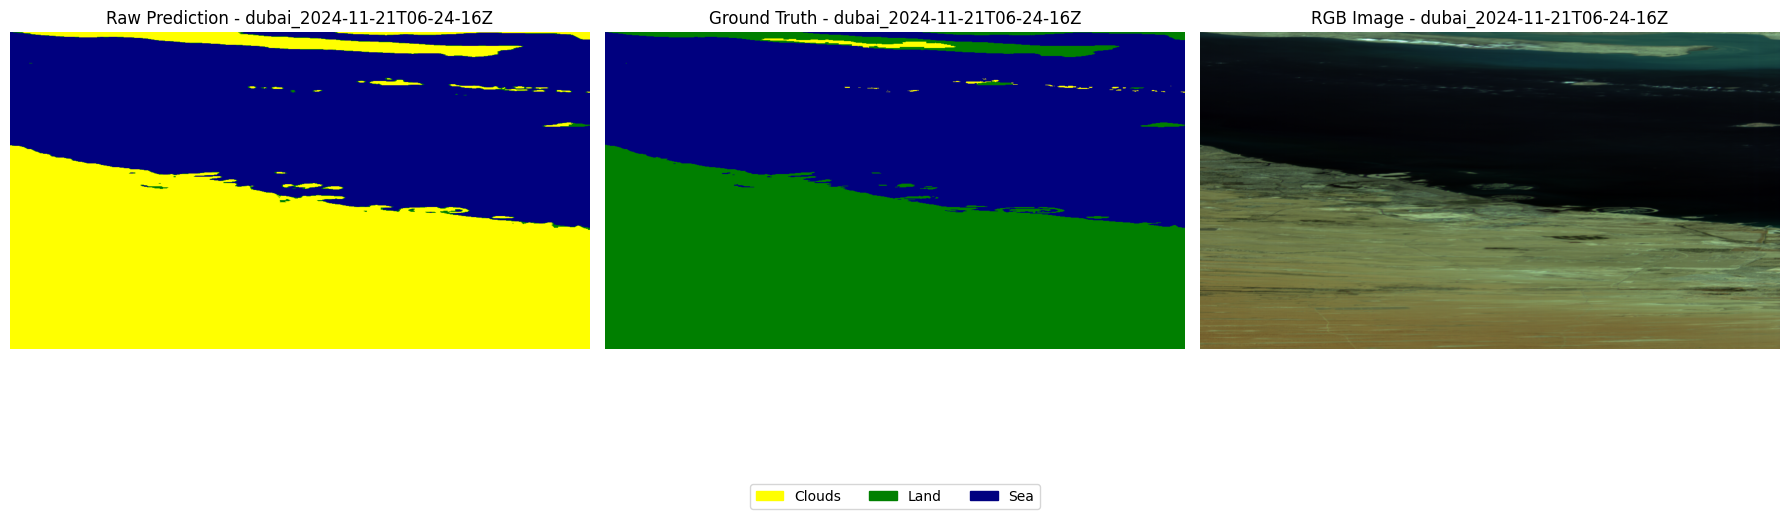

Scene: dubai_2024-11-21T06-24-16Z
OA: 0.476593222830681
AA: 0.660289602183162
Kappa: 0.3209555844408716
              precision    recall  f1-score   support

      Clouds     0.0083    0.9895    0.0164      2860
        Land     0.4248    0.0045    0.0088    339202
         Sea     0.9987    0.9869    0.9928    310954

    accuracy                         0.4766    653016
   macro avg     0.4773    0.6603    0.3393    653016
weighted avg     0.6963    0.4766    0.4774    653016



In [ ]:

# Define class names and color map (same as original ground truth)
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),    # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert dictionary to a ListedColormap for Matplotlib
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# ✅ Pre-load the correct ground truth labels for the test files
# Assuming label_filenames and labels are defined elsewhere.
# testing_label_dict = {
#     os.path.basename(fname).replace("-l1a_labels.dat", ""): label
#     for fname, label in zip(label_filenames, labels)
# }

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(num_components, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")

for img_idx, test_img_filename in enumerate(testing_filenames):
    scene_name = os.path.basename(test_img_filename).replace('-l1d.nc', '')
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue

    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    test_img = testing_files[img_idx]

    test_data = TestPatchSet([test_img], patch_size=16, stride=2)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    pred_patches = []
    confidence_scores = []

    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)

        out = best_model(data)
        probs = F.softmax(out, dim=1)

        max_probs, pred = torch.max(probs, dim=1)

        pred_patches.append(pred.detach().cpu().numpy())
        confidence_scores.append(max_probs.detach().cpu().numpy())

    pred_patches = np.concatenate(pred_patches, axis=0)
    confidence_scores = np.concatenate(confidence_scores, axis=0)

    original_shape = test_img.shape[:2]

    pred_map = reconstruct_image_with_confidence(
        pred_patches,
        confidence_scores,
        original_shape,
        patch_size=16,
        stride=2
    )

    print(f"Unique classes in prediction: {np.unique(pred_map)}")

    # Match scene name to corresponding L1D file using reflectance_data_files
    matching_l1d_file = None
    for reflectance_file, l1d_file in zip(reflectance_data_files, l1d_files):
        if scene_name in reflectance_file:
            matching_l1d_file = l1d_file
            break

    if matching_l1d_file is not None:
        hyperspectral_data = matching_l1d_file
        rgb_image = spectral.get_rgb(hyperspectral_data, (69, 46, 26))
    else:
        print(f"❌ Warning: No matching L1D file found for {scene_name}, skipping RGB plot.")
        rgb_image = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3))  # Placeholder black image

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Raw Prediction - {scene_name}')
    axes[0].axis("off")

    axes[1].imshow(ground_truth, cmap=custom_cmap)
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")

    axes[2].imshow(rgb_image)
    axes[2].set_title(f'RGB Image - {scene_name}')
    axes[2].axis("off")

    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Evaluation for each image
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    # Adjust predictions to match ground truth labels (1, 2, 3)
    test_pred = test_pred + 1

    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)
    report_log = f"Scene: {scene_name}\nOA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
    report_log += classification_report(test_true, test_pred, target_names=[class_names[i] for i in sorted(class_names.keys())], digits=4, zero_division=0, labels=sorted(class_names.keys()))
    print(report_log)

    # fp = open(os.path.join(SAVE_PATH, f'{scene_name}_classification_report.txt'), 'w+')
    # fp.writelines(report_log)
    # fp.close()